In [51]:
# Standard libs
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
#from IPython.display import HTML

# DataPrep
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
import re
import spacy
nlp = spacy.load('pt_core_news_lg')

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

import plotly.graph_objects as go
from plotly.colors import n_colors

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabriel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/gabriel/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


## Importing Dataset 

In [2]:
df = pd.read_csv('../data/raw/B2W-Reviews01.csv')
df.head(5)

/tmp/ipykernel_122472/2255767118.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/B2W-Reviews01.csv')


,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


## Pre process

In [3]:
# Pre processing
# Apply  regex

def apply_regex(corpus, regex):
    corpus = [re.sub(regex, ' ', x) for x in corpus]
    return corpus

def multiple_regex(corpus, regex_list):
    # Lowcase
    corpus = corpus.apply(lambda x: x.lower())
    # Negation
    corpus = [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' não ', r) for r in corpus]
    # Basix regex
    for regex in regex_list:
        corpus = apply_regex(corpus, regex)
    return corpus

def stemmer(corpus):
    stemmer = RSLPStemmer()
    stemmetized = []
    for sentence in corpus:
        words = [stemmer.stem(word) for word in sentence]
        sentence = ' '.join(words)
        stemmetized.append(sentence)
    return corpus

def lemmatizer(corpus):
    lemmatized = []
    for sentence in corpus:
        doc = nlp(sentence)
        lemmat = ' '.join([token.lemma_ for token in doc])
        lemmatized.append(lemmat)
    return lemmatized

# TIRAR ACENTOS

def data_cleaning(df):
    df = df.copy()
    df.drop_duplicates(inplace=True)
    # Feature engineering
    df['review_text'] = df['review_title'] + ' ' + df['review_text']
    cols=['submission_date', 'reviewer_id', 'product_id', 'product_name', 'product_brand',
          'site_category_lv1', 'site_category_lv2', 'overall_rating', 'reviewer_birth_year',
          'reviewer_gender', 'reviewer_state', 'review_title']
    df.drop(columns=cols, inplace=True)
    df.dropna(inplace=True)
    # Noise removal
    regex_list = [r'www\S+', r'http\S+', r'@\S+', r'#\S+', r'[0-9]+', r'\W', r'\s+', r'[ \t]+$']
    df['review_text'] = multiple_regex(df['review_text'], regex_list)
    df['review_text'] = lemmatizer(df['review_text'])

    return df

## ML classification models
### Base Model

In [4]:
%%time

# Create Feature and Label sets
df_ml = data_cleaning(df.copy())
X = df_ml['review_text']
y = df_ml['recommend_to_a_friend']

print(len(df_ml))

127982
CPU times: user 13min 58s, sys: 889 ms, total: 13min 59s
Wall time: 13min 59s


Stemming avg time: ~ 7 min

Lemma avg time: ~ 14 min

In [5]:
df_ml.to_csv('../data/clean/lemma_orig_index.csv') # type: ignore
df_ml.head(5)   # type: ignore

,recommend_to_a_friend,review_text
0,Yes,bom estar contente com o compra entregar rápid...
1,Yes,preço imbatível ótimo qualidade por apenas r e...
2,Yes,atender todo o expectativa superar em agilidad...
3,Yes,presente mais que desejado meu filho amar pare...
4,Yes,sem duvida excelente o entrega ser em o prazo ...


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # type: ignore
print('Training Data Size:', len(X_train))
print('Testing Data Size: ', len(X_test))

Training Data Size: 102385
Testing Data Size:  25597


In [7]:
pt_stopwords = stopwords.words('portuguese')

count_vect = CountVectorizer(lowercase=True, min_df=2, max_df=0.95, ngram_range=(1,3), stop_words=pt_stopwords)
tfidf_vect = TfidfVectorizer(lowercase=True, min_df=2, max_df=0.95, ngram_range=(1,3), stop_words=pt_stopwords)

X1 = X_train.copy()
X2 = X_train.copy()

X_train_tfidf = tfidf_vect.fit_transform(X1)
X_train_count= count_vect.fit_transform(X2)

In [8]:
%%time

clf = LinearSVC()
clf.fit(X_train_tfidf,y_train)
# Form a prediction set
X_test_tfidf = tfidf_vect.transform(X_test)
predictions = clf.predict(X_test_tfidf)

CPU times: user 2.22 s, sys: 1 µs, total: 2.22 s
Wall time: 2.21 s


In [9]:
def evaluate(y_test, predictions):
    print('precision score: ',metrics.precision_score(y_test, predictions, pos_label="Yes"))  # type: ignore
    print('\n', '------------------', '\n')
    print(metrics.classification_report(y_test, predictions))
    print('\n', '------------------', '\n')
    print(metrics.confusion_matrix(y_test, predictions))

In [10]:
evaluate(y_test, predictions) # type: ignore

f1 score:  0.9475507954008505

 ------------------ 

              precision    recall  f1-score   support

          No       0.85      0.84      0.85      6599
         Yes       0.95      0.95      0.95     18998

    accuracy                           0.92     25597
   macro avg       0.90      0.90      0.90     25597
weighted avg       0.92      0.92      0.92     25597


 ------------------ 

[[ 5551  1048]
 [  950 18048]]


#### Features investigation

In [11]:
# Number of features in bag of words = 232110

print(f'Number of data rows = {X2.shape[0]}') # type: ignore
print(f'Number of features in bag of words = {X_train_count.shape[1]}')

Number of data rows = 102385
Number of features in bag of words = 237116


The ngram_range=(1,3) despite adding important data also makes the matrix really sparse which can lead to failed convergence specially when using CV.

### Grid Search Models

**goal:** minimize false positives (due to imbalanced dataset) and to target negative reviews from users

**metric:** precision

**models:** since most sentiment trained models are in english this option will not be considered a first go. Also due to the limited ammount of data deep learning probably won't fit very well

- Translators take a long time for this amount of data

In [12]:
text_lin_svc = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, min_df=5, max_df=0.85, stop_words=pt_stopwords, max_features=5000)),
                     ('lin_svc', LinearSVC())])

text_rf = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, min_df=5, max_df=0.85, stop_words=pt_stopwords, max_features=5000)),
                     ('rf', RandomForestClassifier())])

text_nb = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, min_df=5, max_df=0.85, stop_words=pt_stopwords, max_features=5000)),
                     ('nb', MultinomialNB())])

text_lr = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, min_df=5, max_df=0.85, stop_words=pt_stopwords, max_features=5000)),
                     ('lr', LogisticRegression())])


parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 3)],
              'tfidf__use_idf': (True, False),
}

pipelines = [text_rf, text_nb, text_lr, text_lin_svc]

In [14]:
for pipe in pipelines:

    precision = metrics.make_scorer(metrics.precision_score, pos_label="Yes")
    grid = GridSearchCV(pipe, parameters, cv=2, verbose=2, scoring=precision, n_jobs=-1)
    grid.fit(X_train, y_train)

    best_precision = grid.best_score_
    best_parameters = grid.best_params_
  
    print('\n', "Current Pipeline: ", pipe[1], '\n')
    print("Best precision: {}".format(best_precision))
    print("Best Parameters:", best_parameters)

    # Scoring Training data 
    print('\n', 'Precision on training data: ', round(grid.score(X_train, y_train), 4))        # type: ignore
    # Scoring Test data 
    print('Precision on test data: ', round(grid.score(X_test, y_test), 4), '\n')      # type: ignore

    print('Confusion Matrix : \n' + str(metrics.confusion_matrix(y_test, grid.best_estimator_.predict(X_test))))    # type: ignore

    print(metrics.classification_report(y_test, grid.best_estimator_.predict(X_test))) # type: ignore

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END ....tfidf__ngram_range=(1, 1), tfidf__use_idf=False; total time= 1.6min
[CV] END .....tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time= 1.7min
[CV] END .....tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time= 1.7min
[CV] END ....tfidf__ngram_range=(1, 1), tfidf__use_idf=False; total time= 1.7min
[CV] END ....tfidf__ngram_range=(1, 2), tfidf__use_idf=False; total time= 1.8min
[CV] END .....tfidf__ngram_range=(1, 2), tfidf__use_idf=True; total time= 1.8min
[CV] END .....tfidf__ngram_range=(1, 2), tfidf__use_idf=True; total time= 1.8min
[CV] END ....tfidf__ngram_range=(1, 2), tfidf__use_idf=False; total time= 1.9min
[CV] END .....tfidf__ngram_range=(1, 3), tfidf__use_idf=True; total time= 2.2min
[CV] END ....tfidf__ngram_range=(1, 3), tfidf__use_idf=False; total time= 2.3min
[CV] END ....tfidf__ngram_range=(1, 3), tfidf__use_idf=False; total time= 2.3min
[CV] END .....tfidf__ngram_range=(1, 3), tfidf__u

/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

[CV] END .....tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   4.3s
[CV] END ....tfidf__ngram_range=(1, 1), tfidf__use_idf=False; total time=   4.7s


/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....tfidf__ngram_range=(1, 1), tfidf__use_idf=False; total time=   5.6s
[CV] END .....tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   5.8s


/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....tfidf__ngram_range=(1, 2), tfidf__use_idf=True; total time=   9.0s
[CV] END ....tfidf__ngram_range=(1, 2), tfidf__use_idf=False; total time=   9.8s
[CV] END ....tfidf__ngram_range=(1, 2), tfidf__use_idf=False; total time=   9.9s
[CV] END .....tfidf__ngram_range=(1, 2), tfidf__use_idf=True; total time=  10.4s


/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....tfidf__ngram_range=(1, 3), tfidf__use_idf=True; total time=  14.0s
[CV] END .....tfidf__ngram_range=(1, 3), tfidf__use_idf=True; total time=  15.2s


/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....tfidf__ngram_range=(1, 3), tfidf__use_idf=False; total time=  15.0s
[CV] END ....tfidf__ngram_range=(1, 3), tfidf__use_idf=False; total time=  15.4s
[CV] END .....tfidf__ngram_range=(2, 3), tfidf__use_idf=True; total time=  12.6s
[CV] END ....tfidf__ngram_range=(2, 3), tfidf__use_idf=False; total time=  11.8s
[CV] END ....tfidf__ngram_range=(2, 3), tfidf__use_idf=False; total time=  12.4s
[CV] END .....tfidf__ngram_range=(2, 3), tfidf__use_idf=True; total time=  12.6s


/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Current Pipeline:  LogisticRegression() 

Best precision: 0.9423498510824917
Best Parameters: {'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': False}

 Precision on training data:  0.9491
Precision on test data:  0.9452 

Confusion Matrix : 
[[ 5551  1048]
 [  912 18086]]
              precision    recall  f1-score   support

          No       0.86      0.84      0.85      6599
         Yes       0.95      0.95      0.95     18998

    accuracy                           0.92     25597
   macro avg       0.90      0.90      0.90     25597
weighted avg       0.92      0.92      0.92     25597

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END .....tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   4.9s
[CV] END .....tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   5.1s
[CV] END ....tfidf__ngram_range=(1, 1), tfidf__use_idf=False; total time=   5.0s
[CV] END ....tfidf__ngram_range=(1, 1), tfidf__use_idf=False; total time=   5.3s
[CV] END ....t

### Grid Search Hyperarameters

In [15]:
opt_svc = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, min_df=5, max_df=0.85, stop_words=pt_stopwords, max_features=5000, ngram_range=(1, 3), use_idf=False)),
                     ('svc', LinearSVC(class_weight='balanced'))])

parameters_svc = {'svc__C':[0.1,1,10,100,1000],
                'svc__loss':['hinge', 'squared_hinge'], 
}

In [16]:
svc_grid = GridSearchCV(opt_svc, parameters_svc, cv=2, verbose=2, scoring=precision, n_jobs=-1, refit=True)
svc_grid.fit(X_train, y_train)

best_precision = svc_grid.best_score_
best_parameters = svc_grid.best_params_
# ADD PIPELINE NAME
print('\n', "Current Pipeline: ", opt_svc[1], '\n')
print("Best precision: {}".format(best_precision))
print("Best Parameters:", best_parameters)

# Scoring Training data
print('\n', 'Precision on training data: ', round(svc_grid.score(X_train, y_train), 4))        # type: ignore
# Scoring Test data
print('Precision on test data: ', round(svc_grid.score(X_test, y_test), 4), '\n')      # type: ignore

print('Confusion Matrix : \n' + str(metrics.confusion_matrix(y_test, svc_grid.best_estimator_.predict(X_test))))    # type: ignore

print(metrics.classification_report(y_test, svc_grid.best_estimator_.predict(X_test))) # type: ignore

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END ........................svc__C=0.1, svc__loss=hinge; total time=  13.8s
[CV] END ........................svc__C=0.1, svc__loss=hinge; total time=  13.9s
[CV] END ................svc__C=0.1, svc__loss=squared_hinge; total time=  14.3s
[CV] END ..........................svc__C=1, svc__loss=hinge; total time=  14.2s
[CV] END ..........................svc__C=1, svc__loss=hinge; total time=  14.5s
[CV] END ................svc__C=0.1, svc__loss=squared_hinge; total time=  14.8s
[CV] END ..................svc__C=1, svc__loss=squared_hinge; total time=  14.8s
[CV] END ..................svc__C=1, svc__loss=squared_hinge; total time=  15.5s


/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .........................svc__C=10, svc__loss=hinge; total time=  20.0s
[CV] END .........................svc__C=10, svc__loss=hinge; total time=  20.2s
[CV] END ........................svc__C=100, svc__loss=hinge; total time=  22.5s


/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........................svc__C=100, svc__loss=hinge; total time=  23.4s
[CV] END .................svc__C=10, svc__loss=squared_hinge; total time=  23.9s
[CV] END .................svc__C=10, svc__loss=squared_hinge; total time=  24.5s
[CV] END ................svc__C=100, svc__loss=squared_hinge; total time=  25.9s
[CV] END ................svc__C=100, svc__loss=squared_hinge; total time=  27.3s


/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......................svc__C=1000, svc__loss=hinge; total time=  23.2s


/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......................svc__C=1000, svc__loss=hinge; total time=  23.6s
[CV] END ...............svc__C=1000, svc__loss=squared_hinge; total time=  21.2s
[CV] END ...............svc__C=1000, svc__loss=squared_hinge; total time=  21.3s

 Current Pipeline:  LinearSVC(class_weight='balanced') 

Best precision: 0.9698867112982654
Best Parameters: {'svc__C': 0.1, 'svc__loss': 'hinge'}

 Precision on training data:  0.9726
Precision on test data:  0.971 

Confusion Matrix : 
[[ 6091   508]
 [ 1962 17036]]
              precision    recall  f1-score   support

          No       0.76      0.92      0.83      6599
         Yes       0.97      0.90      0.93     18998

    accuracy                           0.90     25597
   macro avg       0.86      0.91      0.88     25597
weighted avg       0.92      0.90      0.91     25597



In [17]:
# joblib.dump(svc_grid.best_estimator_, '../../models/svc_pipeline_no_cleaning.pkl', compress = 1)

### Model understanding

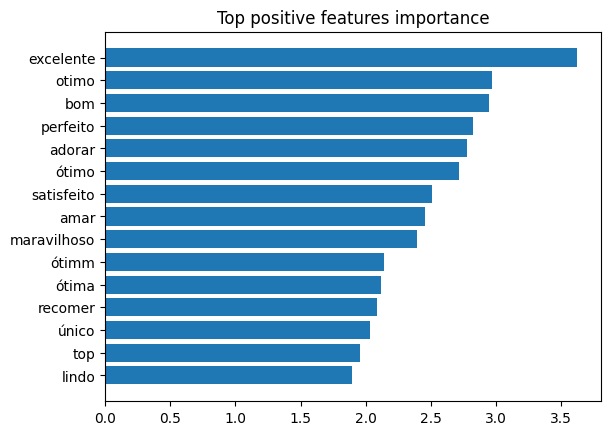

In [18]:
# Importance of features

def f_importances(coef, names, top=True):
    '''
    Print features importance
    Top = True: print top features
    Top = False: print bottom features
    '''
    imp = coef
    imp,names= zip(*sorted(zip(imp,names)))
    if top:
        imp,names = imp[-15:],names[-15:]
        plt.title('Top positive features importance')
    else:
        imp,names = imp[:15],names[:15]
        plt.title('Top negative features importance')
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

f_importances(svc_grid.best_estimator_.named_steps["svc"].coef_[0], svc_grid.best_estimator_.named_steps["tfidf"].get_feature_names_out()) # type: ignore

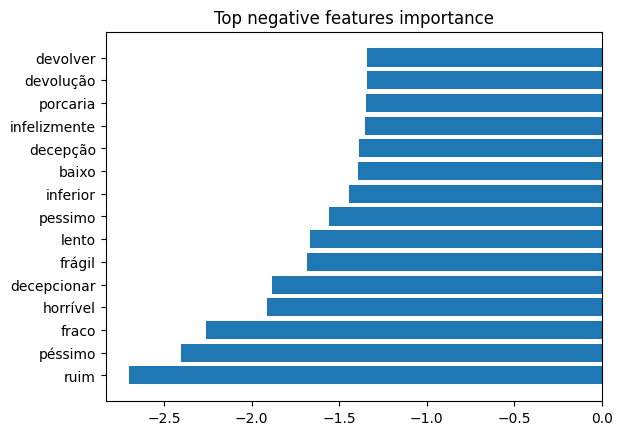

In [19]:
f_importances(svc_grid.best_estimator_.named_steps["svc"].coef_[0], svc_grid.best_estimator_.named_steps["tfidf"].get_feature_names_out(), top=False) # type: ignore

In [81]:
# ver score por categorias ou análise assim

def score_by_category(df, X=X_test):
    tested_df = df.iloc[X.index]
    tested_df['predictions'] = svc_grid.best_estimator_.predict(X)  # type: ignore

    results_df = pd.DataFrame(columns=['site_category_lv1', 'precision', 'recall', 'f1-score', 'accuracy', 'samples'])
    for category in tested_df['site_category_lv1'].unique():
        true_values = tested_df[tested_df['site_category_lv1'] == category]['recommend_to_a_friend']
        predictions = tested_df[tested_df['site_category_lv1'] == category]['predictions']
        if len(predictions) != 0:
            cat_results= pd.Series([category, 
                        round(metrics.precision_score(true_values, predictions, pos_label='Yes'), 4),   # type: ignore
                        round(metrics.recall_score(true_values, predictions, pos_label='Yes'),4),   # type: ignore
                        round(metrics.f1_score(true_values, predictions, pos_label='Yes'),4),   # type: ignore
                        round(metrics.accuracy_score(true_values, predictions),4),  # type: ignore
                        len(true_values)], # type: ignore
                        index=['site_category_lv1', 'precision', 'recall', 'f1-score', 'accuracy', 'samples'])
            results_df = pd.concat([results_df, cat_results.to_frame(1).T], ignore_index=True)

    return results_df

test_results = score_by_category(df)
cm = sns.color_palette("RdYlGn", as_cmap=True)
test_results.style.background_gradient(cmap=cm, subset=['precision', 'recall', 'f1-score', 'accuracy']) # type: ignore

/tmp/ipykernel_122472/1593879408.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,site_category_lv1,precision,recall,f1-score,accuracy,samples
0,Livros,0.975700,0.937200,0.956100,0.924600,783
1,Celulares e Smartphones,0.981500,0.917600,0.948500,0.918500,4037
2,Informática,0.959700,0.880300,0.918300,0.884700,772
3,Automotivo,0.971500,0.853600,0.908700,0.880100,742
4,Brinquedos,0.970900,0.906500,0.937600,0.914900,940
5,Utilidades Domésticas,0.971000,0.901600,0.935000,0.907500,1610
6,Beleza e Perfumaria,0.967300,0.895600,0.930100,0.897400,1735
7,Eletroportáteis,0.971800,0.935200,0.953200,0.924400,2289
8,Ferramentas e Jardim,0.973600,0.850000,0.907600,0.871100,349
9,Esporte e Lazer,0.969000,0.857500,0.909900,0.887700,552


In [82]:
train_results = score_by_category(df, X_train)
train_results.style.background_gradient(cmap=cm, subset=['precision', 'recall', 'f1-score', 'accuracy'])    # type: ignore

/tmp/ipykernel_122472/1593879408.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/home/gabriel/nlp-test-neoway/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning:

F-score is ill-defined and bein

,site_category_lv1,precision,recall,f1-score,accuracy,samples
0,Brinquedos,0.972400,0.895900,0.932600,0.907500,3631
1,Esporte e Lazer,0.962500,0.855600,0.905900,0.886000,2289
2,TV e Home Theater,0.973900,0.898900,0.934900,0.903000,5938
3,Ferramentas e Jardim,0.977600,0.852200,0.910600,0.877200,1327
4,Celulares e Smartphones,0.978500,0.914400,0.945400,0.915200,16173
5,Beleza e Perfumaria,0.968400,0.903100,0.934600,0.906200,6994
6,Informática e Acessórios,0.969100,0.880600,0.922700,0.900100,5736
7,Games,0.976000,0.870200,0.920100,0.891000,2726
8,Móveis,0.969200,0.837800,0.898700,0.891700,5372
9,Utilidades Domésticas,0.966500,0.916800,0.941000,0.913700,6373


**Further work:**
- Tune hyperparameters from probability based models (lr, rf) 
    - Obtain metrics such as ROC and precision recall curve
    - Adjust threshold for reducing false positives

**Insights dos modelos:**


## (TO-DO) Create Pipelines

In [ ]:
class DataCleaning(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Make a new variable that is rating divided by number of reviews
        X['review_text'] = X['review_title'] + ' ' + X['review_text']
        X.drop_duplicates(inplace=True)
        X.drop(columns=['review_title'], inplace=True)
        X.reset_index(drop=True, inplace=True)
        X['review_text'] = X['review_text'].str.lower().copy()
        X['review_text'] = X['review_text'].str.replace('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', 'negação', regex=True).copy()
        regex_list = [r'www\S+', r'http\S+', r'@\S+', r'#\S+', r'[0-9]+', r'\W', r'\s+', r'[ \t]+$']
        for regex in regex_list:
            X['review_text'] = X['review_text'].str.replace(regex, ' ', regex=True).copy()
        return X

In [ ]:
text_vars = ['review_text', 'review_title']

text_pipeline = Pipeline([('data_cleaning', DataCleaning())])

data_pipeline = ColumnTransformer(
    [
    ('text', text_pipeline, text_vars),
    ],
    remainder='drop'
)

num_transformed = data_pipeline.fit_transform(X) # type: ignore

In [ ]:
# Linear SVC:

pt_stopwords = stopwords.words('portuguese')

text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer(min_df=2, max_df=0.75, ngram_range=(1,3), stop_words=pt_stopwords)),
                         ('clf', LinearSVC()),
])

text_clf_lsvc.fit(X_train, y_train)

In [ ]:
parameters = {'clf_C': [0.25, 0.5, 0.75, 1],
                'clf_kernel': ['linear', 'rbf'],
                'clf_gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
grid_search = GridSearchCV(estimator = text_clf_lsvc,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 3,
                           n_jobs = 2)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

In [ ]:
# Form a prediction set
predictions = text_clf_lsvc.predict(X_test)